# roc curve graph
test differnt plots for roc curves and show the *AUC* for these

### 2 cases
* Good algorithms
* Random algorithms

In [105]:
## seteamos los parametros del notebook
%autosave 180
%matplotlib inline
import matplotlib.pyplot as plt
%pylab inline
import pandas as pd; 
import numpy as np; 
import os;
import random;
import time
import seaborn as sns

np.random.seed(2015)
project_dir = os.getcwd().split('/')
project_dir = "/".join(project_dir[:project_dir.index('authorea')+1])
os.chdir(project_dir)

Autosaving every 180 seconds
Populating the interactive namespace from numpy and matplotlib


/Users/jampper/Virtualenvs/sklearn-dv/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [106]:
!ls

ASDFSFD__.tex
Expect_calG_calN_calE_calL__.tex
Pi_Pi_Pi__.tex
Random_Forests_are_a_special__.tex
asdf__.tex
bibliography
figures
header.tex
images
layout.md
o_As_we_know_the__.tex
roc_curve_graph.ipynb
section_Brief_introduction_to_machine__1.tex
section_Datasources_subsection_Argentina_subsection__.tex
section_Gradient_Boosting_Variation_subsection__.tex
section_Introduction_section_Datasource__.tex
section_Introduction_textbf_TODO_LO__1.tex
section_Machine_Learning_in_Practice__.tex
section_Meta_Section_Writing_plan__.tex
subsection_Classification_Scoring_Metrics_Metrics__.tex
subsection_Cross_Validation_textbf_Cross__.tex
subsubsection_A_working_example_For__.tex
textbf_ACA_ARRANCAN_LAS_DESCRIPCIONES__.tex
textbf_Overfitting_subsection_Brief_comment__.tex
title.tex
trash.aux
trash.log
trash.out
trash.pdf
trash.synctex.gz
trash.tex
vaIn_ref_figure_biasVariance_Hastie__.tex


In [263]:
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.cross_validation import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.preprocessing import *
from sklearn.naive_bayes import *

#from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Import some data to play with
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target
#y = label_binarize(y, classes=[0, 1,2])

In [264]:
X.shape, y.shape

((569, 30), (569,))

### random noise

In [265]:
n_classes = 2#y.shape[1]

# Get new dataset with noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X_noise = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# Classify on original X

In [266]:
## split train test

In [267]:
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)


X_train = pd.DataFrame(X_train) 
X_test = pd.DataFrame(X_test)
#X_test = pd.DataFrame(X_test)

## Poly , scaled features

In [268]:
def get_X_files(tables, scaled=False, poly2=False):
    #como input tiene que ir una lista de tables donde la tabla donde se fitea todo viene PRIMERA, i.e. en la pos 0
    #tiene que suceder que haya consistencia entre las columnas de c/dataframe tambien
    train_table = tables[0]
    
    categorical_cols = []
    count_time_cols = [col for col in train_table.columns]
    
    print("First input dataframe is %s big" % str(train_table.shape))
    #print("Test dataframe is %s big" % str(test_table.shape))
    

    
    if scaled ==True :
            min_max_scaler = MinMaxScaler().fit(train_table)
            train_table = min_max_scaler.transform(train_table)
    
    #hacemos interacciones polinomiales sobre las columnas de count/time
    if poly2 == True:
        #pensar que hacer polynomial features es masomenos como agregar nˆ2 nuevas columnas
        #con lo cual tenemos que tener cuidado en no reventar la memoria, ponemor las primeras 50 columnas 
        #como tope para aplicar interacciones polinomiales

        poly2_transform = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
        max_cols = 30

        if  (train_table.shape[1] <= max_cols):
            max_cols = train_table.shape[1]
        poly2_transform.fit(train_table[:,0:max_cols])

        train_table = poly2_transform.transform(train_table[:,0:max_cols])
    
    print("Processed input dataframe is %s big" % str(X_train.shape))
    
    processed_tables = [pd.DataFrame(train_table)]
    
    #aca basicamente replicamos lo anterior pero para todo el resto de las tablas y utilizando los fits que ya tenemos

    for i, table in enumerate(tables):
        # skip the X_train table which comes in the first postion and will behave as our special fitting table
        if i ==0:
            continue  
        #table_categorical = table[categorical_cols].values
        #table_count_time = table[count_time_cols].values
        
        if scaled ==True :
            table = min_max_scaler.transform(table)

        #hacemos interacciones polinomiales sobre las columnas de count/time
        if poly2 == True:
            #pensar que hacer polynomial features es masomenos como agregar nˆ2 nuevas columnas
            #con lo cual tenemos que tener cuidado en no reventar la memoria, ponemor las primeras 50 columnas 
            #como tope para aplicar interacciones polinomiales

            table = poly2_transform.transform(table)
        
        
        
        processed_tables = processed_tables + [pd.DataFrame(table)]
    
    for i in range(len(processed_tables)):    
        print("Table {0} shape is {1}".format( i,str(processed_tables[i].shape)))
#        print("Table %s categorical shape is %s" % str(X_val_categorical.shape))
#        print("Val non-categorical shape is %s" % str(X_val_count_time.shape))
#        print("Val categorical shape is %s" % str(X_val_categorical.shape))
    
    return tuple(processed_tables)
    

In [269]:
type(X_train), type(X_test)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [270]:
X_train,X_test = get_X_files([X_train,X_test], scaled=True, poly2=False)

First input dataframe is (455, 30) big
Processed input dataframe is (455, 30) big
Table 0 shape is (455, 30)
Table 1 shape is (114, 30)


In [271]:
y_series = pd.Series(y_train)
y_series.name = 'y'

corr_matrix = abs(pd.concat([X_train,y_series],axis=1).corr())
corr_matrix.head(3)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,y
0,1.000000,0.316083,0.998185,0.987094,0.164226,0.508985,0.669625,0.823662,0.130193,0.330992,...,0.281647,0.966220,0.941185,0.116935,0.403744,0.511501,0.736397,0.149669,0.004484,0.724320
1,0.316083,1.000000,0.322445,0.318626,0.023107,0.241977,0.298975,0.292473,0.064376,0.071964,...,0.908182,0.354636,0.348051,0.093454,0.273151,0.298302,0.289088,0.098803,0.115940,0.409289
2,0.998185,0.322445,1.000000,0.986692,0.197597,0.555299,0.705993,0.850247,0.161548,0.286012,...,0.288406,0.970507,0.941920,0.145972,0.442236,0.545424,0.762361,0.171204,0.035518,0.736496


In [272]:
with_target_correlation = corr_matrix[corr_matrix['y']>0.5]
with_target_correlation.shape

(16, 31)

In [273]:
with_target_correlation.head(5)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,y
0,1.000000,0.316083,0.998185,0.987094,0.164226,0.508985,0.669625,0.823662,0.130193,0.330992,...,0.281647,0.966220,0.941185,0.116935,0.403744,0.511501,0.736397,0.149669,0.004484,0.724320
2,0.998185,0.322445,1.000000,0.986692,0.197597,0.555299,0.705993,0.850247,0.161548,0.286012,...,0.288406,0.970507,0.941920,0.145972,0.442236,0.545424,0.762361,0.171204,0.035518,0.736496
3,0.987094,0.318626,0.986692,1.000000,0.170459,0.500276,0.679675,0.823160,0.131129,0.302548,...,0.276386,0.959382,0.958527,0.120212,0.380076,0.498019,0.712975,0.126243,0.008425,0.699521
5,0.508985,0.241977,0.555299,0.500276,0.643792,1.000000,0.879782,0.832933,0.583548,0.540311,...,0.257121,0.583536,0.511644,0.577326,0.865480,0.818573,0.825494,0.501795,0.685937,0.612290
6,0.669625,0.298975,0.705993,0.679675,0.503715,0.879782,1.000000,0.914627,0.477989,0.326375,...,0.299400,0.713638,0.668894,0.442474,0.735011,0.880653,0.856157,0.387143,0.506538,0.691016


In [307]:
# choose approximating function
method = 'svm'
#method = 'bnb'
#method = 'rf'

In [308]:
# Learn to predict each class against the other
start_time = time.time()

if method == 'svm':
    
    param_grid = {'kernel':['rbf','linear'], 'C': list(float(10)**np.arange(-2,2)),
                 }
    
    svm_clf = svm.SVC(kernel='linear', probability=True,
                                     random_state=random_state)
    clf =GridSearchCV(svm_clf, param_grid, scoring='roc_auc', fit_params=None, n_jobs=-1, iid=True, refit=True, 
    verbose=2, pre_dispatch='2*n_jobs', error_score='raise')
    
    y_score = clf.fit(X_train, y_train).predict_proba(X_test)



if method == 'bnb':

    param_grid = {'alpha':[1e-3, 1e-1], 'fit_prior': [True],
                 }

    mnb  = BernoulliNB( )

    clf =GridSearchCV(mnb, param_grid, scoring='roc_auc', fit_params=None, n_jobs=-1, iid=True, refit=True, 
    verbose=2, pre_dispatch='2*n_jobs', error_score='raise').fit(X_train, y_train)
    
    mnb = clf.best_estimator_.fit(X_train, y_train)#.feature_log_prob_(X_test)
    y_score = mnb.predict_proba(X_test)
    
if method == 'rf':
    
    param_grid = {'criterion': ['gini','entropy'], 'n_estimators': [4,5,3],
      'max_features': ["auto",10,15,6], "bootstrap": [ False],
        "min_samples_leaf": [4,8],'max_depth':[4,5,6], 
#                   "class_weight": ['balanced']
              }
    rforest  = RandomForestClassifier( )
    clf =GridSearchCV(rforest, param_grid, scoring='roc_auc', fit_params=None, n_jobs=8, iid=True, refit=True, 
        verbose=3, pre_dispatch='2*n_jobs', error_score='raise').fit(X_train, y_train)
    
    rforest = clf.best_estimator_.fit(X_train, y_train)#.feature_log_prob_(X_test)
    y_score = mnb.predict_proba(X_test)
    
elapsed_time =   time.time() - start_time 
print('Grid Search took %s seconds to run' % (elapsed_time))

print('\n Best estimator params was %s \n' % str(clf.best_estimator_))
print('\n Best estimator score was %s \n' % str(clf.best_score_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] C=0.01, kernel=rbf ..............................................
[CV] C=0.01, kernel=rbf ..............................................
[CV] C=0.01, kernel=linear ...........................................
[CV] C=0.01, kernel=rbf ..............................................
[CV] ..................................... C=0.01, kernel=rbf -   0.0s
[CV] ..................................... C=0.01, kernel=rbf -   0.0s
[CV] .................................. C=0.01, kernel=linear -   0.0s
[CV] C=0.01, kernel=linear ...........................................
[CV] C=0.01, kernel=linear ...........................................
[CV] ..................................... C=0.01, kernel=rbf -   0.0s
[CV] C=0.1, kernel=rbf ...............................................
[CV] C=0.1, kernel=rbf ...............................................
[CV] .................................. C=0.01, kernel=linear -   0.0s
[CV] ............

[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.3s finished


In [309]:
y_score.shape

(114, 2)

In [310]:
y_score.shape, y_test.shape

((114, 2), (114,))

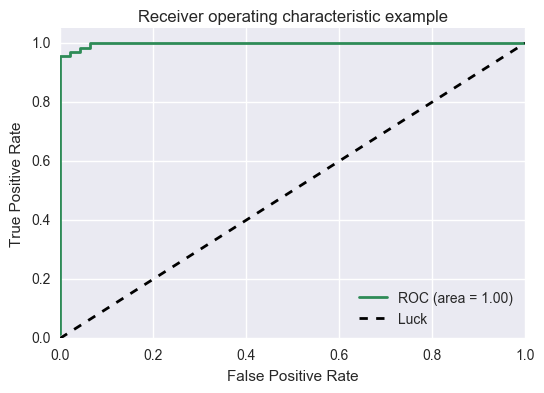

In [311]:
# Compute ROC curve and ROC area 

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

fpr, tpr, thresholds = roc_curve(y_test, y_score[:, 1])
mean_tpr += interp(mean_fpr, fpr, tpr)
mean_tpr[0] = 0.0
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=lw, color='seagreen',
         label='ROC (area = %0.2f)' % ( roc_auc))

plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= clf.n_splits_
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
#plt.plot(mean_fpr, mean_tpr, color='r', linestyle='--', label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
